<a href="https://colab.research.google.com/github/v-y-l/Agenda/blob/master/Data%20Mining%20-%20IEOR%204540.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 3

**Problem 3: Linearization of the feedforward layers in Neural Networks**

Consider a feedforward layer of the following form, where $\mathbf{W} \in \mathbb{R}^{d \times d}, \mathbf{x}, \mathbf{y} \in \mathbb{R}^d$ :
$$
\mathbf{y}=f(\mathbf{W} \mathbf{x})                        
$$

Assume that $f$ is a GELU function. Propose an algorithm to approximate it via the following "linearized variant", where $\Phi: \mathbb{R}^{d \times d} \rightarrow \mathbb{R}^{d \times m}, \Psi: \mathbb{R}^d \rightarrow \mathbb{R}^m$ are some functions (to be constructed by you):
$$
\mathbf{y}^{\prime}=\Phi(\mathbf{W}) \Psi(\mathbf{x}) .
$$

The approximation does not need to be unbiased. Can you propose the unbiased variant ?


# Jicheol, Lisa, Victor: Context

## Creating a synthetic dataset


In [ ]:
import math
import matplotlib.pyplot as plt
import torch
from scipy.special import erf

In [ ]:
import numpy as np

# Choosing d = 10 so we can see meaningful interactions between features
# via weights, but small enough to visualize and run efficient experiments.
d = 10

# Don't use np.random.rand(d, 1), which doesn't consider negatives since it
# takes a uniform distribution of [0,1]. Our dataset should consider negatives,
# since gelu accepts them.
#
# Mean = 0, std dev = 1 should be fine, since most inputs are normalized anyway.
x = np.random.normal(loc=0, scale=1, size=(d, 1))
print("Layer shape of x: ", x.shape)
print(x)


W = np.random.normal(loc=0, scale=1, size=(d, d))
print("Layer shape of W: ", W.shape)
print(W)


Layer shape of x:  (10, 1)
[[ 1.50427133]
 [ 0.12883938]
 [ 2.25638834]
 [ 0.88788649]
 [ 1.08481095]
 [ 1.45251453]
 [-0.53818156]
 [-0.49495873]
 [-0.26553295]
 [ 0.05059396]]
Layer shape of W:  (10, 10)
[[ 1.66975456  0.52391017  0.63067868 -0.05602936 -0.41535352  1.56239377
  -0.52607486 -0.52445412  0.19798323 -1.54899586]
 [ 1.67165437  2.09326596 -0.1202136  -2.49351689 -0.86552997  0.23419346
  -0.74472836  0.49668319 -1.69102042 -0.22994001]
 [ 1.15991586  0.54098766 -1.12550547 -0.08318706  0.66258887  1.13547324
   0.58006594  1.65811478 -0.13611404  0.3619377 ]
 [ 0.23079591 -1.44466371  0.22468241  0.2947248   0.89686078 -0.29632867
   0.6431502   1.10552663  0.17947478 -1.16208568]
 [ 0.27857126  0.97351403  1.30013342 -0.55359863  0.43286264 -0.52946618
  -1.21382828  0.1856267   0.39737849 -0.17268367]
 [-0.84699473  0.59677227  1.62965161  0.52783984 -0.84032197  2.03213274
  -1.29475423  2.12160854  1.7596552  -0.07258691]
 [-1.23906294 -0.96370007 -1.19646823  0.987

In [ ]:
y = np.matmul(W, x)
print("Layer shape of y: ", y.shape)
print(y)

Layer shape of y:  (10, 1)
[[ 6.18315814]
 [ 0.29269077]
 [ 0.49074109]
 [ 0.47243311]
 [ 3.13419227]
 [ 4.16446378]
 [-4.99106139]
 [ 0.62658407]
 [ 6.41903159]
 [ 4.05464171]]


## GELU through tanh




In [ ]:
# tanh approximation
def gelu_tanh(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

In [ ]:
# erf approximation
def gelu_erf(x):
    return 0.5 * x * (1 + erf(x/np.sqrt(2)))

## True Value of GELU


Given $W$ ∈ $\mathbb{R}^{d\times d}$, $x$, $y$ ∈ $\mathbb{R}^{d}$, another way to approximate is using CDF:

$GELU(x)$ = $x$ $P(X <= x)$ = $x {\Phi}(x)$




In [ ]:
#This section is synonymous to tanh approximation, but using CDF instead. We are using the definition of GELU to set as a standard.
#CDF is the cumulative distribution function for finding area under a standard normal function.

from scipy.stats import norm
phi_x = norm.cdf(y)
print("shape of phi_x: ", phi_x.shape)
print("phi_x: ", phi_x)

GELU_x = y * phi_x
print("shape of GELU_x: ", GELU_x.shape)
print("GELU_x: ", GELU_x)

shape of phi_x:  (10, 1)
phi_x:  [[1.00000000e+00]
 [6.15120739e-01]
 [6.88195210e-01]
 [6.81691163e-01]
 [9.99138361e-01]
 [9.99984396e-01]
 [3.00242029e-07]
 [7.34534042e-01]
 [1.00000000e+00]
 [9.99974894e-01]]
shape of GELU_x:  (10, 1)
GELU_x:  [[ 6.18315814e+00]
 [ 1.80040165e-01]
 [ 3.37725669e-01]
 [ 3.22053477e-01]
 [ 3.13149173e+00]
 [ 4.16439879e+00]
 [-1.49852640e-06]
 [ 4.60247328e-01]
 [ 6.41903159e+00]
 [ 4.05453992e+00]]


## **Below we show our biased approximation for a Taylor Series Expansion:**

let
$f(x)= \frac{1}{{\sqrt {2\pi } }}e^{ - \frac{{z^2 }}{2}} = .3989e^{ - 5z^2 }$ be the standard normal density function and

let
$F(x)={\frac{1}{\sqrt{2\pi}}}\int_{-\infty }^{x}e^{-t^{2}/2}\,dt $
be the standard normal cumulative distribution function

We compute a Taylor series expansion:

\begin{equation}
\begin{aligned}
G(x) & =\int \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2} x^2} d x \\
& =\frac{1}{\sqrt{2 \pi}} \int \sum_{n=0}^{\infty} \frac{(-1)^n}{n!2^n} x^{2 n} d x \\
& =\frac{1}{\sqrt{2 \pi}} \sum_{n=0}^{\infty} \frac{(-1)^n}{n!2^n(2 n+1)} x^{2 n+1} \\
& =\frac{1}{\sqrt{2 \pi}}\left(x-\frac{1}{6} x^3+\frac{1}{40} x^5-\frac{1}{336} x^7+\cdots\right)
\end{aligned}
\end{equation}



In [ ]:
#TODO: Fix the +0.5 to the function and multiply by x

def gelu_taylor_basic(x):
  leading_coefficient = 1/math.sqrt(2*math.pi)
  term1 = leading_coefficient * (x)
  term2 = -leading_coefficient * (x**3)/6
  term3 = leading_coefficient * (x**5)/40
  term4 = -leading_coefficient * (x**7)/336
  term5 = leading_coefficient * (x**9)/2480
  term6 = -leading_coefficient * (x**11)/40320
  term7 = leading_coefficient * (x**13)/6227040
  return x*(0.5 + term1 + term2 + term3 + term4)

#Taylor approximation using n terms, recursion
def gelu_taylor_recursive(x, n):
  leading_coefficient = 1/math.sqrt(2*math.pi)
  if n == 0:
    #first term means that there is only x
    #this is the base case
    return 0.5+leading_coefficient *((-1)**n) * (x**(2*n+1))/(math.factorial(n)*(2**n)*(2*n+1))
  else:
    #Recursion step, adding terms iteratively
    return gelu_taylor_recursive(x, n-1) + leading_coefficient * (-1)**n / (math.factorial(n) * (2**n) * (2*n+1)) * x**(2*n+1)

# Taylor approximation using n terms, for-loop
def gelu_taylor(x,n):
  leading_coefficient = 1/np.sqrt(2*np.pi)
  sum = 0
  for i in range(n):
    sum += (-1)**i / (math.factorial(i)* (2**i) * (2*i+1)) * x**(2*i+1)
  return x * (0.5+leading_coefficient*sum)

In [ ]:
#sample input

x = 0.5
n = 100
print("Tanh approximation: ", gelu_tanh(x))
print("Erf approximation: ", gelu_erf(x))
print("Taylor polynomial: ", gelu_taylor(x,n))
print("Base case Taylor polynomial: ", gelu_taylor_basic(x)) # Adding terms by brute force
print("Taylor polynomial, recursive case", x * gelu_taylor_recursive(x,n)) #need to multiply by x because of the function is taylor of standard normal cdf

Tanh approximation:  0.34571400982514394
Erf approximation:  0.3457312306370065
Taylor polynomial:  0.34573123063700656
Base case Taylor polynomial:  0.3457311201736166
Taylor polynomial, recursive case 0.3457312306370065


## **Activation functions show similar trends across five approximations**

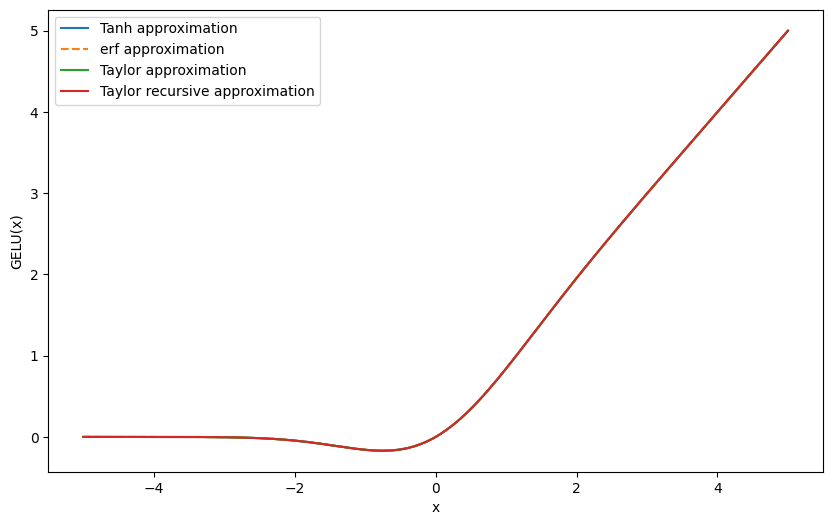

In [ ]:
x = np.linspace(-5, 5, 1000)

plt.figure(figsize = (10,6))
plt.plot(x, gelu_tanh(x), label='GELU (tanh)')
plt.plot(x, gelu_erf(x), label='GELU (erf)', linestyle='--')
plt.plot(x, gelu_taylor(x,100), label='GELU (taylor)', linestyle='-')
plt.plot(x, x*gelu_taylor_recursive(x, 100), label='GELU (taylor_recursive)')
#plt.plot(x, [gelu_MC(i,100) for i in x], label='GELU (MC)', linestyle='-')
plt.xlabel('x')
plt.ylabel('GELU(x)')
plt.legend(['Tanh approximation', 'erf approximation', 'Taylor approximation', 'Taylor recursive approximation', 'Monte Carlo approximation'])
plt.show()

# Victor: **Phi and psi for GELU Taylor Series approximation (biased estimation)**

## Preparing the GELU Taylor Series approximation for decomposition into phi and psi

GELU is an element-wise activation function.

Let the first transformed dimension be $x_1' = W_1x'$. The first row of $W$ is applied to $x$ to produce $x'$.

By working out $\phi$ and $\psi$ for $x_1'$, we can expand it to all dimensions of $x$ wlog.

Approximating GELU using Taylor series = $\frac{x_1'}{2} + \frac{x_1'}{2\pi}\sum_{n=0}^{\infty}\frac{(-1)^n}{n!(2n+1)}x_1'^{2n+1}
= \frac{x_1'}{2} + \frac{(x_1')^2}{\sqrt{2\pi}} - \frac{(x_1')^4}{6\sqrt{2\pi}} + \frac{(x_1')^6}{40\sqrt{2\pi}} - \frac{(x_1')^8}{336\sqrt{2\pi}} + ...$

Notice that once expanded, the approximation takes the form
$a_0(W_1x) + a_1(W_1x)^2 + a_2(W_1x)^4 + ...$


## Defining phi and psi

Each term in the GELU approximation is an exponentiated dot product, that once expanded, can be decomposed into phi and psi using Kronecker products.


### First term

This is easiest to understand by examing the first term:

* $a_1(\sum_{i=1}^{d}w_ix_i)^2$ = $\sum_{i=1}^{d}\sum_{j=1}^{d}(W_i W_j x_i x_j$), where $d$ is the of dimensions of $x$.

For example, when $d = 2$,  $a_0\sum_{i=1}^{2}\sum_{j=1}^{2}(W_i W_j x_i x_j) = w_1^2x_1^2 + w_1w_2x_1x_2 + w_2w_1x_2x_1 + w_2^2x_2^2$.

Which can be written as a dot of:

$\begin{pmatrix}
w_1^2 &&
w_1w_2 &&
w_2w_1 &&
w_2 ^2
\end{pmatrix} \begin{pmatrix} x_1^2 \\
x_1x_2 \\
x_2x_1 \\
x_2 ^2 \end{pmatrix}$


The left side is a Cartesian combination of $W_1$ to itself. The right side is the Cartesian combination of $x$ to itself.

$a_1(\sum_{i=1}^{d}w_ix_i)^2 = a_1*(W  \otimes W) (x \otimes x)^T.$

### Second term

If we apply the same logic, we see that:

$a_2(\sum_{i=1}^{d}w_ix_i)^4 = a_1*(W  \otimes W \otimes W \otimes W) (x \otimes x \otimes x \otimes x)^T$

## Generalization
$a_n \left(\sum_{i=1}^d w_i x_i\right)^{2n} = a_n \Big( W^{\otimes 2n} \Big) \cdot \Big( x^{\otimes 2n} \Big)^T$, where $n$ is the term.

## Implementation: The 5-term Taylor Series approximation as phi and psi

### 5-term Taylor series approximaton range

This shows us that the $x'$ should be within $[3, 3]$ in our demonstration.

\begin{array}{|c|c|}
\hline
\text{Range of }Wx & \text{Max Error} \\
\hline
[-1,1]   & 9\times10^{-6}        \\
[-3,3]   & 3.0                   \\
[-5,5]   & 7.8\times10^{2}       \\
[-7,7]   & 2.7\times10^{4}       \\
\hline
\end{array}


In [ ]:
# Generate dataset to stay within range of 'good' accuracy
import numpy as np
x = np.array([1,.1,2])
W = np.array([
    [-0.8, -0.8, -0.8],
    [.5, .5, .5],
    [.2, .3, 1]
])
x_prime = W @ x
print("x_prime = Wx = ", x_prime)

x_prime = Wx =  [-2.48  1.55  2.23]


In [ ]:
import math
import numpy as np

class TaylorSeriesGeluEstimator:
    def __init__(self, n_terms):
        self.n = n_terms
        self.coeffs = self._compute_coeffs()
        # exponents for the monomials: [1, 2, 4, 6, …, 2n]
        self.powers = [1] + [2*i + 2 for i in range(self.n)]

    def _compute_coeffs(self):
        """ Gathers the Taylor‐series coefficients [0.5, …] up through n_terms. """
        coeffs = [0.5]
        base = 1 / math.sqrt(2 * math.pi)
        for i in range(self.n):
            c = (-1)**i / (math.factorial(i) * (2**i) * (2*i + 1))
            coeffs.append(base * c)
        return coeffs

    def _kron_n(self, vec, times):
        """ Compute vec ⨂ vec ⨂ … ⨂ vec (times times). """
        out = vec
        for _ in range(times - 1):
            out = np.kron(out, vec)
        return out

    def transform(self, vec, coeffs=None):
        """
        Build a single feature vector:
          [ coeffs[0] * vec^1, coeffs[1] * vec^2, coeffs[2] * vec^4, … ]
        If coeffs is None, we assume all 1’s (for ψ).
        """
        if coeffs is None:
            coeffs = [1.0] * len(self.powers)

        parts = []
        for c, p in zip(coeffs, self.powers):
            parts.append(c * self._kron_n(vec, p))
        return np.concatenate(parts)

    def get_phi(self, W):
        """
        W: 2‑D array of shape (n_rows, d).
        Returns φ of shape (n_rows, feature_dim).
        """
        rows = [self.transform(w, self.coeffs) for w in W]
        return np.vstack(rows)

    def get_psi(self, x):
        """
        x: 1‑D vector of length d.
        Returns ψ of shape (feature_dim,), with no Taylor weights.
        """
        return self.transform(x, coeffs=None)

estimator = TaylorSeriesGeluEstimator(n_terms=5)
phi = estimator.get_phi(W)
psi = estimator.get_psi(x)
phi_dot_psi = phi.dot(psi)

In [ ]:
import math

class GELUComparator:

  def __init__(self, n):
    self.n = n

  # Tanh approximation of Wx
  def gelu_tanh(self, x):
      return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))

  # GELU approximation of Wx using n terms
  def gelu_taylor(self, x):
    n = self.n
    leading_coefficient = 1/np.sqrt(2*np.pi)
    sum = 0
    for i in range(n):
      sum += (-1)**i / (math.factorial(i)* (2**i) * (2*i+1)) * x**(2*i+1)
    return x * (0.5+leading_coefficient*sum)

  def get_error(self, actual, expected):
    return np.sqrt(np.mean((actual - expected)**2))

  def compare_gelu(self, x_prime, phi_dot_psi):
    n = self.n
    print("==== Tanh VS Taylor Series ({0} terms) ====\n".format(n))

    actual_gelu_taylor = self.gelu_taylor(x_prime)
    expected_tanh = self.gelu_tanh(x_prime)
    print("x_prime = Wx = ", x_prime)
    print("gelu_taylor_{0}(x_prime) = {1}".format(n, actual_gelu_taylor))
    print("phi_dot_psi: ", phi_dot_psi)
    print("gelu_tanh(x_prime) = ", expected_tanh)

    error = self.get_error(actual_gelu_taylor, expected_tanh)
    error_phi_dot_psi = self.get_error(actual_gelu_taylor, phi_dot_psi)
    print("\nError of GELU n = {0} against tanh: {1}".format(n, error))
    print("\nError of phi_dot_psi against GELU n = {0}: {1}".format(n,
                                                            error_phi_dot_psi))

GELUComparator(5).compare_gelu(x_prime, phi_dot_psi)

==== Tanh VS Taylor Series (5 terms) ====

x_prime = Wx =  [-2.48  1.55  2.23]
gelu_taylor_5(x_prime) = [0.33582152 1.45766421 2.30608443]
phi_dot_psi:  [0.33582152 1.45766421 2.30608443]
gelu_tanh(x_prime) =  [-0.01585868  1.45591211  2.20158061]

Error of GELU n = 5 against tanh: 0.2118199525143093

Error of phi_dot_psi against GELU n = 5: 9.809465989410858e-15


# Victor: Unbiased estimation using neural networks

In [ ]:
# Big idea: we train one big model that connects phi and psi only at the
# final node, so we can easily remove the final node (to get our phi and psi),
# return the final node in inference basically.

import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader

# 1. Data generation: GELU dataset
class GeluDataset(Dataset):
    def __init__(self, N, d):
        # PyTorch gets us to focus on shape, and we do the transformations
        # ourselves if we want to shift
        #
        # Each x gets its own W
        self.W = torch.randn(N, d, d)
        self.x = torch.randn(N, d)
        # In other words: Z[b, i] = sum_j (W[b, i, j] * x[b, j])
        #
        # 'bj -> bi' is a compact way to express which dimension (j) to dot over.
        # 'bi' is the destination shape: one output per i, for each example b.
        # We're summing over 'j' — which corresponds to W's columns — to merge it away.
        Z = torch.einsum('bij,bj->bi', self.W, self.x)
        self.y = 0.5 * Z * (1 + torch.erf(Z / math.sqrt(2)))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.W[idx], self.x[idx], self.y[idx]

# 2. Ψ-network: x -> m features
class PsiNet(nn.Module):
    def __init__(self, d, m, hidden=64):
        super().__init__()
        # Visaully, a line of nodes
        self.net = nn.Sequential(
            # Learn a bunch of numbers: project input x ∈ ℝᵈ into a hidden space.
            # If d < hidden, we're expanding — giving the network more room to model patterns.
            # If d > hidden, we're compressing — forcing the network to extract essentials.
            # In both cases, hidden=64 implicitly says: "64 features is the sweet spot" for representing each example.
            nn.Linear(d, hidden),
            # max(0, x) makes the network nonlinear — it breaks additivity and homogeneity.
            # That means we can no longer collapse it into one big linear transformation.
            #
            # Now, the network becomes a series of "maybe this, not that" filters.
            # At each layer, ReLU adds a hard yes/no — some signals don’t make it through.
            nn.ReLU(),
            # arbitrarily say m is the perfect ending
            nn.Linear(hidden, m)
        )

    def forward(self, x):
        return self.net(x)

# 3. Φ-network: W -> d × m matrix (row-wise MLP)
# d is not example's d, it's batch-aware, see
#         ψ = psi(xb)                      # (B, m)
#Φ = phi(Wb)
class PhiNet(nn.Module):
    def __init__(self, d, m, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, hidden),
            nn.ReLU(),
            nn.Linear(hidden, m)
        )

    # we learnt for all W, but apply it independently to each W
    def forward(self, W):
        B, D, _ = W.shape
        W_flat = W.reshape(B * D, D)
        out_flat = self.net(W_flat)            # (B*D, m)
        return out_flat.view(B, D, -1)         # (B, d, m)

# Hyperparameters
d, m, N, batch_size, epochs = 2, 16, 1024, 64, 5

# Prepare DataLoader
dataset = GeluDataset(N, d)
loader  = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate models.
psi = PsiNet(d, m)
phi = PhiNet(d, m)

# Optimizer & loss
optimizer = torch.optim.Adam(list(psi.parameters()) + list(phi.parameters()), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
for epoch in range(1, epochs+1):
    total_loss = 0.0
    for Wb, xb, yb in loader:
        optimizer.zero_grad()
        # we feed phi and psi batches - basically back to back into one row
        # once the object is declared, it assumes minibatches when you call obj(minibatch), and updates the underlying nodes
        ψ = psi(xb)                      # (B, m)
        Φ = phi(Wb)                      # (B, d, m)

        # PyTorch builds one big comp graph for the forward pass,
        # joining the two nets. Mini-batch also useful for speed.
        #
        # bmm is batch matrix mult, 3d to 3d; add dummy axis then remove
        # TODO(vyl): convert to einsum, prefer that
        y_pred = torch.bmm(Φ, ψ.unsqueeze(-1)).squeeze(-1)  # (B, d)

        # Under the hood, each nn.Module (my two nets) registers its own weights
        # as nn.Parameter, and PyTorch’s autograd links them into one big
        # computation graph.

        # When I backprop, every parameter’s .grad is filled
        loss = criterion(y_pred, yb)
        loss.backward()
        # When I step, the optimizer loops over them all to the update rule.
        #     optimizer.step() actually updates phi and psi using loss
        optimizer.step()
        total_loss += loss.item() * Wb.size(0)

      # Key insight: under the hood, PyTorch builds a computation graph.
      # So we can write code declaratively — just describe what happens.
      # During .backward(), PyTorch walks the graph in reverse and computes gradients.
        #         ψ = psi(xb)         # → Tensor with attached grad_fn
        # Φ = phi(Wb)         # → Another Tensor with grad_fn
        # y_pred = bmm(Φ, ψ)  # → Graph combines both paths
        # loss = criterion(y_pred, yb)
    print(f"Epoch {epoch}: MSE = {total_loss / N:.4f}")

Epoch 1: MSE = 0.8069
Epoch 2: MSE = 0.3371
Epoch 3: MSE = 0.1785
Epoch 4: MSE = 0.1396
Epoch 5: MSE = 0.1193


In [ ]:
# Testing this...

import numpy as np
def gelu_tanh(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))

# Inference on a new pair
with torch.no_grad():
    W_test = torch.randn(1, d, d)
    x_test = torch.randn(1, d)
    ψ_test = psi(x_test)                      # (1, m)
    Φ_test = phi(W_test)                      # (1, d, m)
    y_approx = torch.bmm(Φ_test, ψ_test.unsqueeze(-1)).squeeze().numpy()
    print("y_approx =", y_approx)
    print("y_true =", gelu_tanh(W_test @ x_test.T))

y_approx = [-0.11181282  0.18113723]
y_true = tensor([[[-0.1460],
         [ 0.1667]]])


<ipython-input-2-dc9e478d3b1f>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * np.power(x, 3))))


# Lisa: Biased Estimation Optimization

## **Reference Point Z_bar**


A common deterministic (and therefore typically biased) approximation is something like a firstorder Taylor expansion. Concretely, for:


$$
y=\operatorname{GELU}(W x) \quad \in \mathrm{R}^d
$$
we pick a reference point $\bar{x}$ (or equivalently $\bar{z}=W \bar{x}$ ) and do


$$
\operatorname{GELU}(W x) \approx \operatorname{GELU}(\bar{z})+\operatorname{diag}\left(\operatorname{GELU}^{\prime}(\bar{z})\right)[W(x-\bar{x})]
$$


We can write that in the form


$$
\Phi(W) \Psi(x)
$$
by letting (for each dimension $d$ ):
- $\Phi(W)=\left[\operatorname{diag}\left(\operatorname{GELU}^{\prime}(\bar{z})\right) W, \operatorname{GELU}(\bar{z})\right]_{\text {, }}$
- $\Psi(x)=\left[\begin{array}{c}x-\bar{x} \\ 1\end{array}\right]$.



In [ ]:

d = 10

x = np.random.normal(loc=0, scale=1, size=(d, 1))
print("Layer shape of x: ", x.shape)
print(x)

W = np.random.normal(loc=0, scale=1, size=(d, d))
print("Layer shape of W: ", W.shape)
print(W)

Layer shape of x:  (10, 1)
[[-0.54482853]
 [-0.63161671]
 [-0.91564961]
 [-1.61399943]
 [-0.32162195]
 [-0.99222462]
 [-0.43824675]
 [-1.00634214]
 [-0.67069234]
 [-0.52997316]]
Layer shape of W:  (10, 10)
[[ 0.15442335  0.3980553  -0.52444445 -0.98954088  0.20999811  0.71897845
   0.02773517  0.64994208  0.60642394 -0.36017352]
 [-0.22911784  0.68378315 -0.54357769  0.70303585  0.67343318  0.56204901
   2.0718752  -0.61541612 -0.57229049 -0.06937265]
 [-0.33748318  0.91634761  0.72224767  0.23208452 -0.19391651 -0.06156583
  -0.64269339  0.97637855 -0.91726821  0.35681976]
 [-1.76898045 -1.70892249  1.19247607  0.46073594 -0.89124224 -0.88789947
  -0.04999247 -0.6534811   0.28152786  1.34730197]
 [-1.03744554 -1.21432242 -1.41537019 -0.50120456 -0.21842279 -0.2192634
   1.3374741  -0.21391763 -1.56546067  0.43102527]
 [-0.09136713  1.04181634  0.33211971  0.91217382 -1.77372231 -0.62776832
  -0.93404803 -0.5788386  -0.03663755 -0.09564729]
 [ 1.08729511 -0.00797789 -0.1177749  -0.3980

In [ ]:
reference_point_z_bar = np.matmul(W, x)
print("reference_point_z_bar shape: ", reference_point_z_bar.shape)
print("reference_point_z_bar: ", reference_point_z_bar)

reference_point_z_bar shape:  (10, 1)
reference_point_z_bar:  [[ 0.07878448]
 [-1.58637833]
 [-1.58217787]
 [ 1.15197815]
 [ 4.17559271]
 [-0.12413107]
 [ 1.8729242 ]
 [ 0.60285136]
 [ 3.4256965 ]
 [ 1.49600314]]




```
# This is formatted as code
```

**The Derivative of GELU (tanh approximation) is:**

$
\frac{\tanh\left(\frac{\sqrt{2} \left(\frac{8943x^{3}}{200000} + x\right)}{\sqrt{\pi}}\right) + 1}{2} + \frac{x \left(\frac{26829x^{2}}{200000} + 1\right) \operatorname{sech}^{2}\left(\frac{\sqrt{2} \left(\frac{8943x^{3}}{200000} + x\right)}{\sqrt{\pi}}\right)}{\sqrt{2} \sqrt{\pi}}
$


- $\Phi(W)=\left[\operatorname{diag}\left(\operatorname{GELU}^{\prime}(\bar{z})\right) W, \operatorname{GELU}(\bar{z})\right]_{\text {, }}$
- $\Psi(x)=\left[\begin{array}{c}x-\bar{x} \\ 1\end{array}\right]$.

In [ ]:
#import sympy
# Use sympy functions for symbolic calculations, including sympy.tanh and sympy.sqrt
#f = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
#df_dx = sympy.diff(f, x)

def sech(x):
  #just sech(x)
  return 1 / np.cosh(x)

def df_dx(x):
  df_dx = (np.tanh((np.sqrt(2) * ((8943 * x**3) / 200000 + x)) / np.sqrt(np.pi)) + 1) / 2 + (x * ((26829 * x**2) / 200000 + 1) * sech((np.sqrt(2) * ((8943 * x**3) / 200000 + x)) / np.sqrt(np.pi))**2) / (np.sqrt(2) * np.sqrt(np.pi))
  return df_dx

print("original equation: 0.5 * x * (1 + tanh(sqrt(2 /π) * (x + 0.044715 * x**3)))" )
print("")
print("shape of derivative equation output: ", df_dx(reference_point_z_bar).shape)
print("derivative equation output: ", df_dx(reference_point_z_bar))

#
#print("")
#print("derivative at reference point: ", df_dx_at_reference_point_z_bar)

original equation: 0.5 * x * (1 + tanh(sqrt(2 /π) * (x + 0.044715 * x**3)))

shape of derivative equation output:  (10, 1)
derivative equation output:  [[ 0.5627304 ]
 [-0.12389785]
 [-0.12413379]
 [ 1.11175594]
 [ 1.00015044]
 [ 0.40146715]
 [ 1.09960235]
 [ 0.92704488]
 [ 1.00313472]
 [ 1.12783005]]


In [ ]:
phi = [np.matmul(np.diag(df_dx(reference_point_z_bar)), W), gelu_tanh(reference_point_z_bar)]
print("diag: ", np.diag(df_dx(reference_point_z_bar)).shape)
print("W: ", W.shape)

psi = [x - reference_point_z_bar, 1]
print("phi shape: ", phi.shape)
print("phi: ", phi)
print("psi shape: ", psi.shape)
print("psi: ", psi)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 1)

**This concludes the biased section**

# Jicheol: Unbiased estimation

TODO: These get better with more attempts (e.g. Monte Carlo-based approximation).

## **Approximating GELU using Monte Carlo simulation of sample size alpha = N and 1D variable x**

## GELU Interpretation
\begin{equation}
\begin{aligned}
&\begin{aligned}
\operatorname{GELU}(z) & =x \Phi(x), x \in \mathbb{R} \\
& =x \cdot P(z \leq x), Z \sim N(0,1) \\
& =x \cdot E[1\{z \leq x\}], \text { where } 1(x)= \begin{cases}1, & z \leq x \\
0, & z>x \\\end{cases}
& \approx x \cdot \frac{1}{N} \sum_{i=1}^N 1_{z_i \leq x} \end{aligned}\\
&\text { and as } N \rightarrow \infty \text { this converges to } \operatorname{GELU}(x)
\end{aligned}
\end{equation}

Given W_x is interpreted as:


\begin{equation}
w_x=
\begin{bmatrix}
    \omega_{x_{1,1}} & \omega_{x_{1,2}} & \omega_{x_{1,3}} & \dots  & \omega_{x_{1,n}} \\
    \omega_{x_{2,1}} & \omega_{x_{2,2}} & \omega_{x_{2,3}} & \dots  & \omega_{x_{2,n}} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \omega_{x_{d,1}} & \omega_{x_{d,2}} & \omega_{x_{d,3}} & \dots  & \omega_{x_{d,n}}
\end{bmatrix}
\end{equation}




**We want to find $\Phi(\omega)$ and $\psi(x)$ s.t.**
$$
\begin{array}{cl}
f\left(w_x\right)_{i j}=\left(w_x\right)_{i j} \cdot \Phi\left(\left(w_x\right)_{i j}\right) & i=1, \ldots R \\ & j =1, \ldots D \\
\text { or } f\left(w_x\right)=w_x \odot \Phi\left(w_x\right) &
\end{array}
$$

$ \odot $ here is an elementwise product. total of RD elementwise approximations.



\begin{aligned}
\therefore f\left(w_x\right)_{i j} & =\operatorname{GELU}\left(\left(w_x\right)_{i j}\right) \\
& \approx \frac{1}{N} \sum\left(w_x\right)_{i j} \cdot 1 z_k^{i j} \leq\left(w_x\right)_{i j}, z_k^{(i j)} \backsim N(0,1)
\end{aligned}

**So we would like to find a solution to accomodate W_x:**
$$
G\left(w_x{(i, j)}\right) \approx \frac{1}{\sqrt{2 \pi}} \sum_{n=0}^{\infty} \frac{(-1)^n}{2^n n!(2 n+1)}\left(w_x{(i,j)}\right)^{2 n+1}
$$

In [ ]:
# Output is an unbiased estimator of the true value
def gelu_MC(x, N):
    success = 0
    for _ in range(N):
        z = np.random.normal(0, 1)
        if z <= x:
            success += 1
    return (success / N) * x

print("Monte Carlo approximation:", gelu_MC(x,n)) #this value changes every time due to random sampling

NameError: name 'x' is not defined